In [1]:
#!/usr/bin/env python3
#in this script we will extract and downsample the B cells in the panfetal atlas dataset

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [2]:
adata = ad.read_h5ad("/g/data/yr31/hb1618/iPSC_project/datasets/panfetal_whole/panfetal_whole.h5ad")

In [3]:
print(adata)

AnnData object with n_obs × n_vars = 911873 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [4]:
#first we will subset out the cell type of interest
cell_types_to_keep = ["MATURE_B"]
adata = adata[adata.obs['celltype_annotation'].isin(cell_types_to_keep)].copy() 

In [5]:
print(adata)

AnnData object with n_obs × n_vars = 17489 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'


In [6]:
#examine the donor metadata
adata.obs["donor"]

FCAImmP7579224-TACTTGTCAGCTGGCT    F45
FCAImmP7579224-CGGAGTCAGCAGGCTA    F45
FCAImmP7579224-TATTACCCACCACCAG    F45
FCAImmP7579224-TGTGTTTCACGGTAGA    F45
FCAImmP7579224-CAGCAGCTCGGATGGA    F45
                                  ... 
FCAImmP7803020-AGGGATGGTCGCGAAA    F50
FCAImmP7803020-CGATCGGGTAGAGCTG    F50
FCAImmP7803020-ACACCGGGTGTCTGAT    F50
FCAImmP7803020-CGATGTAGTCTGCGGT    F50
FCAImmP7277565-GGACATTTCCGTTGCT    F30
Name: donor, Length: 17489, dtype: category
Categories (24, object): ['F19', 'F21', 'F22', 'F23', ..., 'F71', 'F72', 'F73', 'F78']

In [7]:
#performing quality control
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

In [8]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True
)

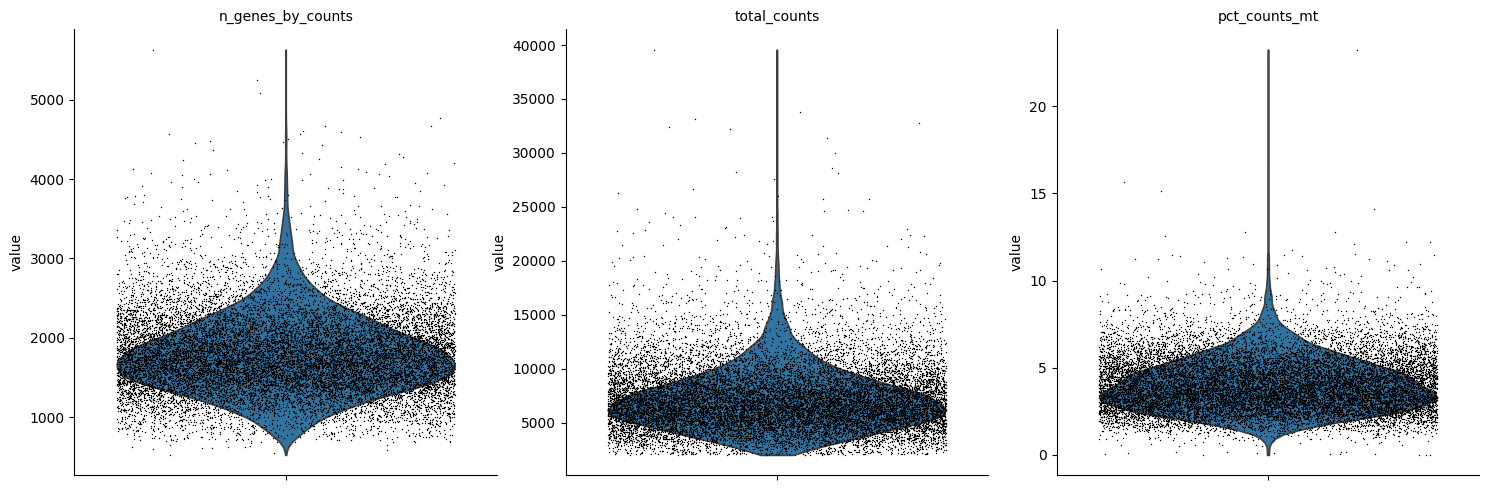

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

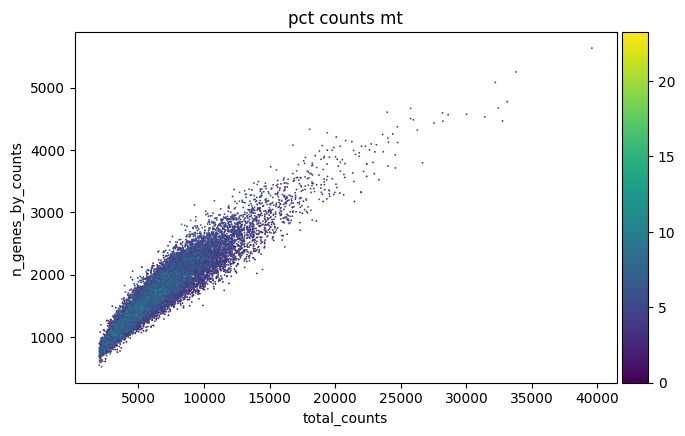

In [10]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [11]:
#it seems that QC has already been applied to the above cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt'] < 10].copy()

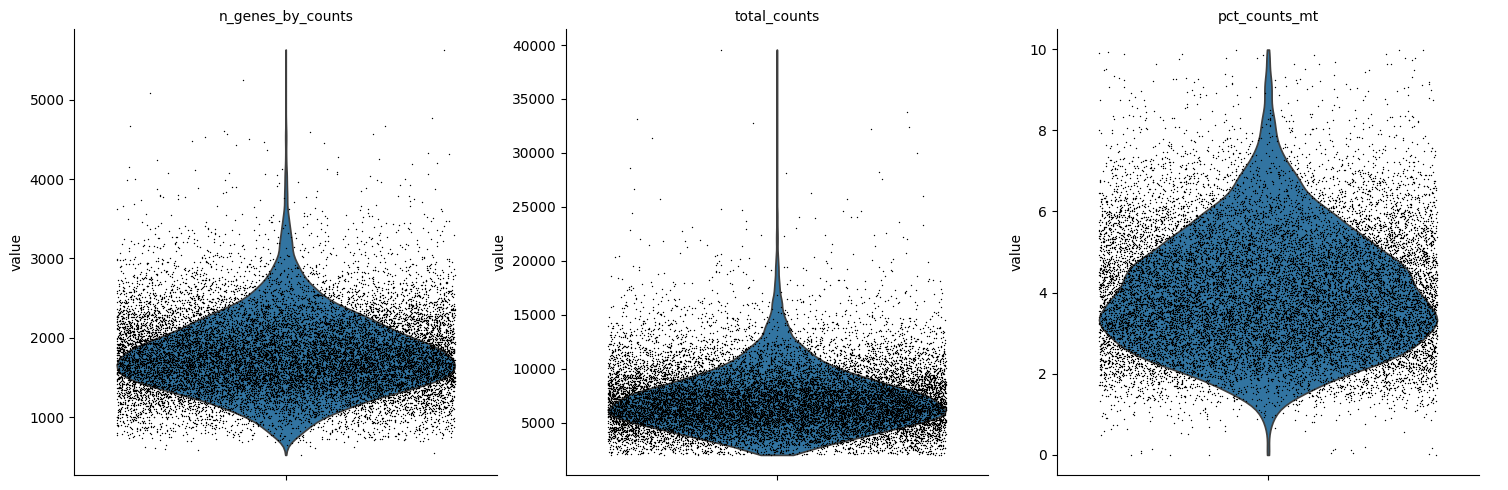

In [12]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [13]:
adata.obs['predicted_doublets'].value_counts()

predicted_doublets
False    17435
True         6
None         1
Name: count, dtype: int64

In [14]:
adata = adata[adata.obs['predicted_doublets'] == 'False'].copy()

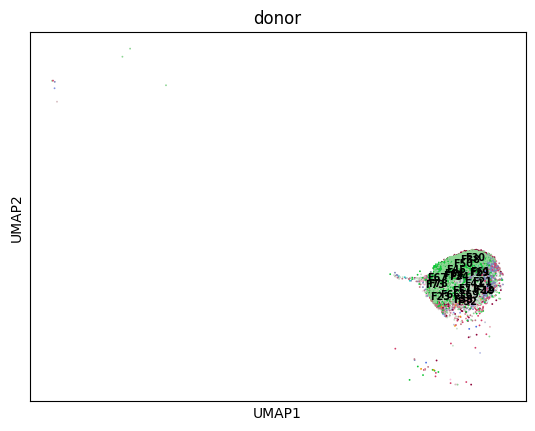

In [15]:
sc.pl.umap(adata,color='donor', legend_loc='on data', legend_fontsize='x-small')

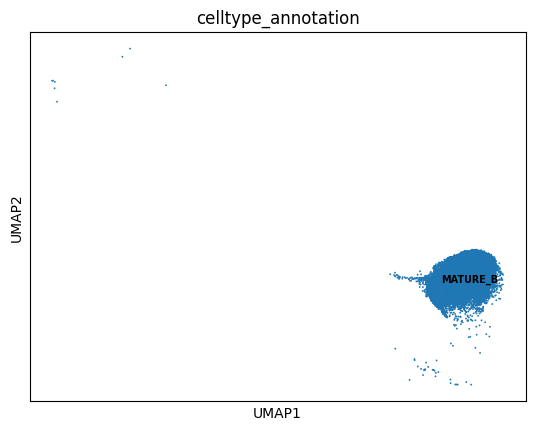

In [16]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

In [17]:
adata.obs['donor'].value_counts()

donor
F29    4339
F51    4214
F45    1963
F30    1923
F21    1702
F50    1538
F38     482
F41     377
F71     261
F78     145
F72     114
F23      94
F73      87
F66      70
F33      68
F67      24
F34       9
F32       8
F35       5
F22       5
F61       2
F69       2
F19       2
F64       1
Name: count, dtype: int64

In [20]:
# In order to get 3-5 donors, and ~5000 cells, we will select donors F45, F30 and F21
donors_to_keep = ["F45", "F30", "F21"]
adata = adata[adata.obs['donor'].isin(donors_to_keep)].copy() 

In [21]:
print(adata)

AnnData object with n_obs × n_vars = 5588 × 18813
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'leiden', 's

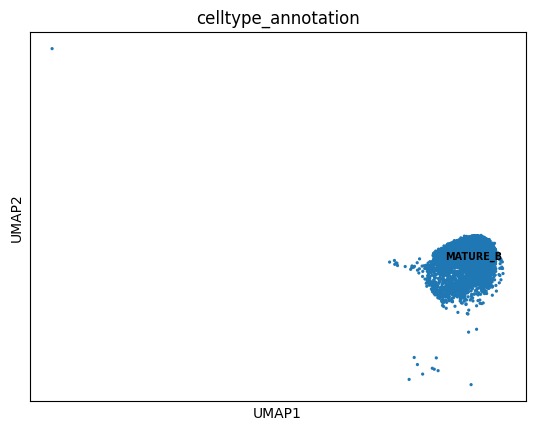

In [22]:
sc.pl.umap(adata,color='celltype_annotation', legend_loc='on data', legend_fontsize='x-small')

In [24]:
adata.obs['celltype_annotation'].value_counts()

celltype_annotation
MATURE_B    5588
Name: count, dtype: int64

In [25]:
#exporting extracted data
#exporting count data

# Convert to DataFrame with cells as rows, genes as columns
count_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

In [26]:
# Save the DataFrame to a .tsv file
count_df.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/B_top3/B_top3_countdata.tsv", sep='\t')

In [28]:
#exporting metadata
# Save the observation metadata (cell-level annotations) as a CSV file
adata.obs.to_csv("/g/data/yr31/hb1618/iPSC_project/datasets/multi_benchmark/B_top3/B_top3_metadata.csv")